<a href="https://colab.research.google.com/github/abs711/makemore/blob/master/Makemore_usingMLP_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore using a Multi-layer Perceptron

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words)))) # Get all the characters
stoi = {s:i+1 for i,s in enumerate(chars)} #string to integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [ ]:
n_dim = 2 #embedding dimensions
block_size = 3 # context length i.e. num of character used to predict the next character
hu = 100 # num of hidden tanh layer units
X, Y = [], []

for w in words:#[:5]:
#     print(w + '.')
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]


X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,n_dim,generator=g) # randomized two dimensional embedding for 27 characters

In [ ]:
# C[5] or equivalently F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# C[[5,6,7]] = C[torch.tensor([5,6,7])] #torch.tensor vs torch.Tensor
#C[X].shape = torch.Size([32, 3, 2])
# X[13,2] = 1 => C[X][13,2] = C[1]
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((block_size*n_dim,hu),generator=g)
b1 = torch.randn(hu,generator=g)
W1.shape, b1.shape


(torch.Size([6, 100]), torch.Size([100]))

In [ ]:
W2 = torch.randn((hu,27),generator=g)
b2 = torch.randn(27,generator=g)
W2.shape, b2.shape


(torch.Size([100, 27]), torch.Size([27]))

In [ ]:
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

3481


In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
for epc in range(1000):

    ix  = torch.randint(0,X.shape[0], (32,),generator=g) # minibatch
    emb = C[X[ix]] #[32, 3, 2]
    emb = emb.view(-1,block_size*n_dim) #== torch.cat(torch.unbind(emb,1),dim=1) == torch.cat([emb[:,i,:] for i in range(block_size)],dim=1)
    h = torch.tanh(emb@W1 + b1) # see below or refer to broadcasting rules
    # h.shape
    # 32, 100
    # 1,  100
    logits = h@W2 + b2
    # count = logits.exp()
    # probs = count/count.sum(1, keepdims=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # Efficient Forward and Backward pass; Also, prevent overflow due to exponentiation of large logits
    if epc%100==0:
        print('epc:', epc, 'loss:', loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.001 #lrs[epc]

    for p in parameters:
        p.data += -lr*p.grad

    lri.append(lr)
    lossi.append(loss.item())


epc: 0 loss: 2.360083818435669
epc: 100 loss: 2.6191487312316895
epc: 200 loss: 2.189039707183838
epc: 300 loss: 2.1864209175109863
epc: 400 loss: 2.3310015201568604
epc: 500 loss: 2.5891337394714355
epc: 600 loss: 2.3867485523223877
epc: 700 loss: 2.5220494270324707
epc: 800 loss: 2.202450752258301
epc: 900 loss: 2.6760952472686768


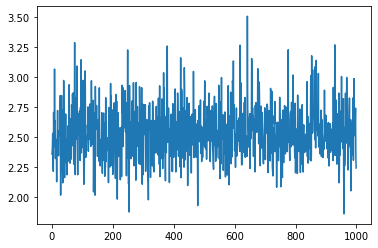

In [ ]:
plt.plot(lossi)

In [ ]:
emb = C[X[ix]] #[32, 3, 2]
emb = emb.view(-1,block_size*n_dim)
h = torch.tanh(emb@W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Y[ix])
print('loss:', loss.item())


loss: 2.238490581512451


tensor(17.7697)